# Reservas de hoteis

## Contexto
Os canais de reserva de hotéis online mudaram drasticamente as possibilidades de reserva e o comportamento dos clientes. Um número significativo de reservas de hotéis são canceladas devido a cancelamentos ou não comparecimentos. Os motivos típicos para cancelamentos incluem mudança de planos, conflitos de agendamento, etc. Isso geralmente é facilitado pela opção de fazê-lo gratuitamente ou, de preferência, a um baixo custo, o que é benéfico para os hóspedes do hotel, mas é um fator menos desejável e possivelmente de redução de receita para os hotéis lidarem.

#### Você consegue prever se o cliente vai honrar a reserva ou cancelá-la?

## Importações e carregando o Dataset

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Carregando o dataset
hotel_data = pd.read_csv("data/hotel_reservations.csv")

## Pré-processamento de dados

### Medindo correlação das features

Primeiramente, precisamos sanitizar nosso dataset visando uma melhor qualidade dos dados

In [2]:
# Removendo colunas de ID e colunas não relevantes para a previsão
hotel_data.drop(columns=['Booking_ID', 'arrival_year', 'arrival_date'], inplace=True)

# Convertendo variáveis categóricas para numéricas
hotel_data = pd.get_dummies(hotel_data, columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], drop_first=True)

# Transformando a variável que queremos prever em numérica: (1: cancelada, 0: não cancelada) 
label_encoder = LabelEncoder()
hotel_data['booking_status'] = label_encoder.fit_transform(hotel_data['booking_status'])

# Normalização de atributos (Excluindo-se a variável de reservas)
scaler = MinMaxScaler()
features_hotel = hotel_data.drop(columns=['booking_status'], errors='ignore')
hotel_data[features_hotel.columns] = scaler.fit_transform(features_hotel)

# Separando features e labels para os dois conjuntos de dados (Treinamento e teste)
#X_hotel = hotel_data.drop(columns=["booking_status"])
#y_hotel = hotel_data["booking_status"]

# Criando a matriz de correlação
correlation_matrix = hotel_data.corr()
    
# Filtrando apenas a correlação com a variavel de Status de Reserva
cor_target = correlation_matrix["booking_status"].drop("booking_status")

# Ordenando da maior para a menor correlação absoluta
cor_target_sorted = cor_target.abs().sort_values(ascending=False)
print(cor_target_sorted)


lead_time                               0.438538
no_of_special_requests                  0.253070
avg_price_per_room                      0.142569
market_segment_type_Corporate           0.112993
repeated_guest                          0.107287
market_segment_type_Online              0.106362
no_of_week_nights                       0.092996
no_of_adults                            0.086920
type_of_meal_plan_Meal Plan 2           0.086370
required_car_parking_space              0.086185
market_segment_type_Complementary       0.072867
no_of_weekend_nights                    0.061563
no_of_previous_bookings_not_canceled    0.060179
market_segment_type_Offline             0.038351
no_of_previous_cancellations            0.033728
no_of_children                          0.033078
room_type_reserved_Room_Type 6          0.032652
room_type_reserved_Room_Type 7          0.014062
room_type_reserved_Room_Type 4          0.013309
arrival_month                           0.011233
room_type_reserved_R

Analisando o resultado da medição de correlação podemos identificar que as seguintes colunas: room_type_reserved_Room_Type 3, room_type_reserved_Room_Type 2, type_of_meal_plan_Meal Plan 3, type_of_meal_plan_Not Selected e room_type_reserved_Room_Type 5 podem ser removidas devido à apresentarem uma correlação insignificante (> 0.1) com a coluna que queremos prever.

In [3]:
#Definindo a nossa nova base de dados processada
hotel_data_processed = hotel_data.drop(columns=['room_type_reserved_Room_Type 2',
                                        'type_of_meal_plan_Meal Plan 3', 
                                        'room_type_reserved_Room_Type 3', 
                                        'type_of_meal_plan_Not Selected',
                                        'room_type_reserved_Room_Type 5'])

#### Exibição dos dados processados


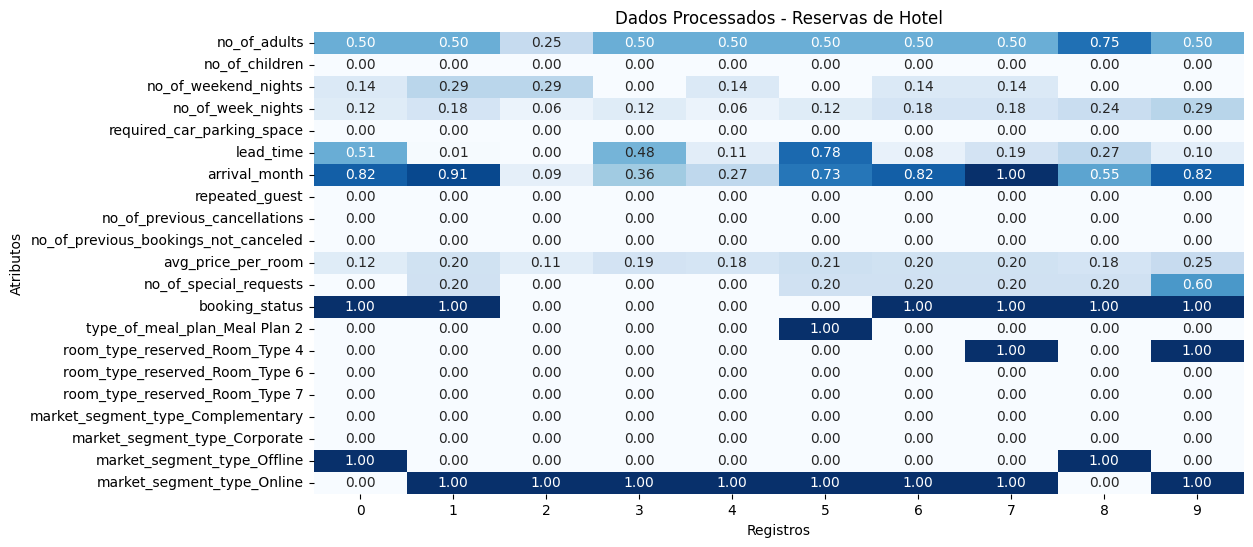

In [4]:
def plot_table(df, title):
    transposed_df = df.head(10).T
    plt.figure(figsize=(12, 6))
    sns.heatmap(transposed_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Registros")
    plt.ylabel("Atributos")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()

plot_table(hotel_data_processed, "Dados Processados - Reservas de Hotel")

## Definindo a validação cruzada

In [5]:
# Definindo o número de folds
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Separando features e labels para os dois conjuntos de dados (Treinamento e teste)
X_hotel = hotel_data_processed.drop(columns=["booking_status"])
y_hotel = hotel_data_processed["booking_status"]

# Criando os folds
folds_hotel = list(skf.split(X_hotel, y_hotel))
print(f"Criados {k} folds para o dataset")


Criados 10 folds para o dataset


## Arvores de decisão

Em primeiro momento vamos testar a classificação utilizando os parâmetros default da árvore apenas alterando o seu critério de classificação entre Gini e Entropy

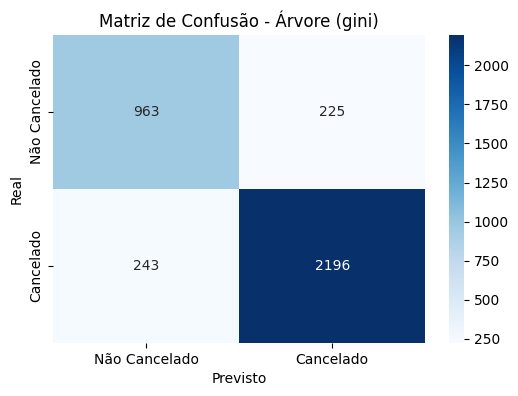

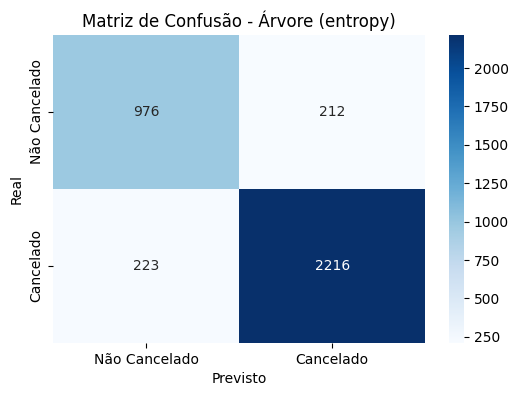


Resultados da Árvore de Decisão (k-fold cross-validation):
        Acurácia Média Desvio Padrão F1-score (Não Cancelado)  \
gini            86.81%         0.55%                   80.45%   
entropy         87.07%         0.68%                   81.78%   

        F1-score (Cancelado)  
gini                  90.37%  
entropy               91.06%  


In [15]:

# Definindo os critérios
criterios = ["gini", "entropy"]

resultados_hotel_arvore = {}

# Treinamento, teste e avaliação do modelo
for criterio in criterios:
    accuracies = []

    for train_idx, test_idx in skf.split(X_hotel, y_hotel):
        X_train, X_test = X_hotel.iloc[train_idx], X_hotel.iloc[test_idx]
        y_train, y_test = y_hotel.iloc[train_idx], y_hotel.iloc[test_idx]

        modelo = DecisionTreeClassifier(criterion=criterio, random_state=42)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))

    # Acurácia
    mean_accuracy = np.mean(accuracies) * 100
    std_accuracy = np.std(accuracies) * 100

    
    last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
    X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
    y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # F1-score
    f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100  # "Não cancelado"
    f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100  # "Cancelado"

    
    resultados_hotel_arvore[criterio] = {
        "Acurácia Média": f"{mean_accuracy:.2f}%",
        "Desvio Padrão": f"{std_accuracy:.2f}%",
        "F1-score (Não Cancelado)": f"{f1_0:.2f}%",
        "F1-score (Cancelado)": f"{f1_1:.2f}%"
    }

    # matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - Árvore ({criterio})")
    plt.show()


df_resultados_arvore = pd.DataFrame(resultados_hotel_arvore).T

print("\nResultados da Árvore de Decisão (k-fold cross-validation):")
print(df_resultados_arvore)


Aproximadamente 87% de acurácia é um bom valor mas acredito que podemos chegar a um valor de acurácia maior. Em primeiro momento vamos utilizar um algoritmo para encontrar os melhores parâmetros de acordo com o nosso problema.

### Tunning de Parâmetros

In [17]:
#Utilizando o GriSearchCV para encontrar os parâmetros que mais se encaixam com o nosso dataset

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_hotel, y_hotel)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia encontrada:", f"{grid_search.best_score_ * 100:.2f}", "%")


Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor acurácia encontrada: 87.73 %


## 2. KNN

Agora que utilizamos o modelo de árvore de decisão vamos usar o knn com duas versões uma com K sendo 5 e outra com K sendo igual a 10.


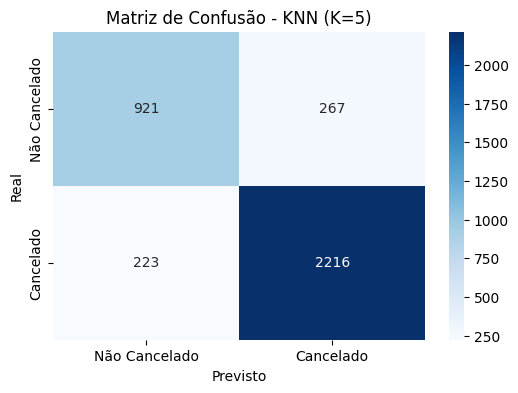

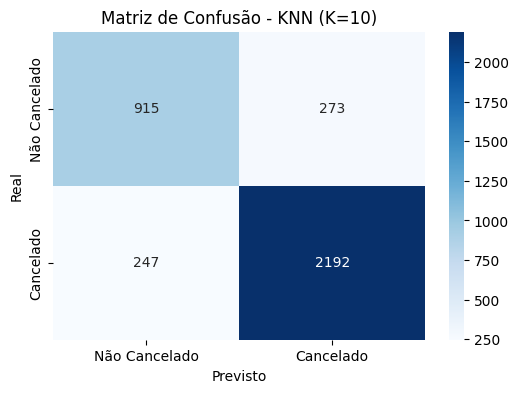


Resultados do KNN (k-fold cross-validation):
   Acurácia Média Desvio Padrão F1-score (Não Cancelado) F1-score (Cancelado)
5          85.85%         0.59%                   78.99%               90.04%
10         85.26%         0.54%                   77.87%               89.40%


In [18]:
K_values = [5, 10]
resultados_hotel_knn = {}

for k in K_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Validação cruzada
    accuracies = cross_val_score(knn_model, X_hotel, y_hotel, cv=skf, scoring="accuracy")

    # Média e desvio padrão da acurácia
    mean_accuracy = np.mean(accuracies) * 100
    std_accuracy = np.std(accuracies) * 100

    # Treinamento e teste
    last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
    X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
    y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    # Calculando f1
    f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100  # "Não cancelado"
    f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100  # "Cancelado"

    # Resultados
    resultados_hotel_knn[k] = {
        "Acurácia Média": f"{mean_accuracy:.2f}%",
        "Desvio Padrão": f"{std_accuracy:.2f}%",
        "F1-score (Não Cancelado)": f"{f1_0:.2f}%",
        "F1-score (Cancelado)": f"{f1_1:.2f}%"
    }

    df_resultados_knn = pd.DataFrame(resultados_hotel_knn).T

    # Exibindo a matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - KNN (K={k})")
    plt.show()


print("\nResultados do KNN (k-fold cross-validation):")
print(df_resultados_knn)


## 3. MLP

Agora vamos utilizar o modelo MLP variando entre 2 arquiteturas.

1. MLP 1:
    - Arquitetura com camadas ocultas de 50 e 25 neurônios

2. MLP 2:
    - Arquitetura com camadas ocultas de 100 e 50 neurônios

_Alem disso vamos alternar entre os parâmetros de ativação *relu* e *tanh*_

In [21]:
from sklearn.neural_network import MLPClassifier

# Definindo arquiteturas
arquiteturas = {
    "MLP 1": (50, 25),
    "MLP 2": (100, 50)
}

# Parâmetros de ativação
ativacoes = ["relu", "tanh"]

# Dicionário de resultados
resultados_mlp = {}


# Treinamento, teste e avaliação dos modelos
for nome_arquitetura, camadas in arquiteturas.items():
    for ativacao in ativacoes:
        accuracies = []

        for train_idx, test_idx in skf.split(X_hotel, y_hotel):
            X_train, X_test = X_hotel.iloc[train_idx], X_hotel.iloc[test_idx]
            y_train, y_test = y_hotel.iloc[train_idx], y_hotel.iloc[test_idx]

            modelo = MLPClassifier(hidden_layer_sizes=camadas, activation=ativacao, max_iter=2000, random_state=42)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            accuracies.append(accuracy_score(y_test, y_pred))

        # Acurácia
        mean_accuracy = np.mean(accuracies) * 100
        std_accuracy = np.std(accuracies) * 100

        # Treinamento 
        last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
        X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
        y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # F1-score
        f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100
        f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100

        # Resultados
        chave = f"{nome_arquitetura} ({ativacao})"
        resultados_mlp[chave] = {
            "Acurácia Média": f"{mean_accuracy:.2f}%",
            "Desvio Padrão": f"{std_accuracy:.2f}%",
            "F1-score (Não Cancelado)": f"{f1_0:.2f}%",
            "F1-score (Cancelado)": f"{f1_1:.2f}%"
        }

        #Data frame
        df_resultados_mlp = pd.DataFrame(resultados_mlp).T

        # Matriz de confusão
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
        plt.xlabel("Previsto")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {chave}")
        plt.show()

print("\nResultados da MLP (k-fold cross-validation):")
print(df_resultados_mlp)
